# Ames Housing Prices

**Task:** Predict the final sale price of a residental home in Ames, Iowa (regression)

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

import seaborn as sns
sns.set_style("darkgrid")

In [3]:
from utils import Compare

### Preamble

(_This analysis took around 3 hours total, including all comments and markup._)

While Kaggle can often be about fine-tuning the solution to squeeze out an extra 0.001% of accuracy, for many real-world business problems, that is a waste of valuable resources. Still, Kaggle can provide us with a toy dataset to demonstrate an efficient approach.

Instead, we'll simulate a business context here, which provides us a modified goal:
- Achieve the highest improvement **relative to a simple benchmark**, **per unit of time invested**.
- Expand the metrics to measure **both average performance, as well as model risk** (variance in prediction error).

This last point is important - in real-world contexts, management may care about situations where the model gives an extremely incorrect prediction. These scenarios can lead to categorically different outcomes from minor errors. For example, they may lead to a support ticket being filed, or or for customers to lose trust in the model (trust being a valuable, yet intangible asset which is hard to rebuild once lost).

It may not be enough to loosely incorporate this KPI into a model training metric such as RMSE, where the model will naturally punish outlier predictions; Management still needs to know that the model we are implementing will actively **reduce** the rate of extremely bad predictions. To provide management with an intuitive metric for this KPI, we can use 95th percentile of errors, or else [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) relative to the target mean.

We'll also add the following constraints:
- We do not examine other team's solutions, since those will not exist in a typical business context.
- We care about explainability of the model - both for internal stakeholders, and our customers.

As we go through the analysis, we have some considerations to guide us:
- **Minimize risk of human error with frequent sanity checking.**
    - More than typical backend code, data-manipulation code often "fails silently". By mistake we may introduce a bug or just take a logically invalid approach - yet unless it throws an error, we won't know that we have compromised the results of our analysis
    - As data scientists we may first learn this when try to evaluate our model's RMSE; as data analysts, it may happen even later - in the worst case, errors are only discovered once when we try to present our work to stakeholders and hear the dreaded words "These numbers aren't making sense, go back and run the analysis again".
    - We must be extra diligent to catch errors in our code as we process data.
- **Be efficient in feature engineering & cleaning**.
    - We'll have 10s-1000s of features in our prediction problems; each of which can require different encoding methods, preprocessing or outlier treatment, etc.
    - If we spend, say, 15-20 minutes minimum on some code that will clean between 1 and 5 features, we might spend days preparing data - only to find in our very first model training run that most of those features do not help the model generalize even with the best encoding methods.
    - To be more efficient, we can iterate on a small feature set initially and work from there.
- **Keep the main part of the code well-factored to be put into production later**.
    - The more we can keep things neat and OOP in our analysis, the less work it will be to put things into production. 

### Analysis - Phase 1

Let's start by looking at the data.

In [4]:
df_import = pd.read_csv("data/train.csv", index_col="Id")

(As this is a toy dataset, we don't have to worry about any of the features being unavailable at prediction time - but in a real-world context this would be a potential concern.)

We'll do two things first:
- Examine the target variable
- Look for the presence of critical features in the dataset, such as groups which largely determine the conditional distribution of the target.

##### Target variable - sale price

Without being real estate experts, from real-world knowledge we expect:
- Number should be [0, +inf]; 
- No values close to 0
- A long tail of higher-priced luxury homes

In [5]:
df = df_import.copy()

<Axes: >

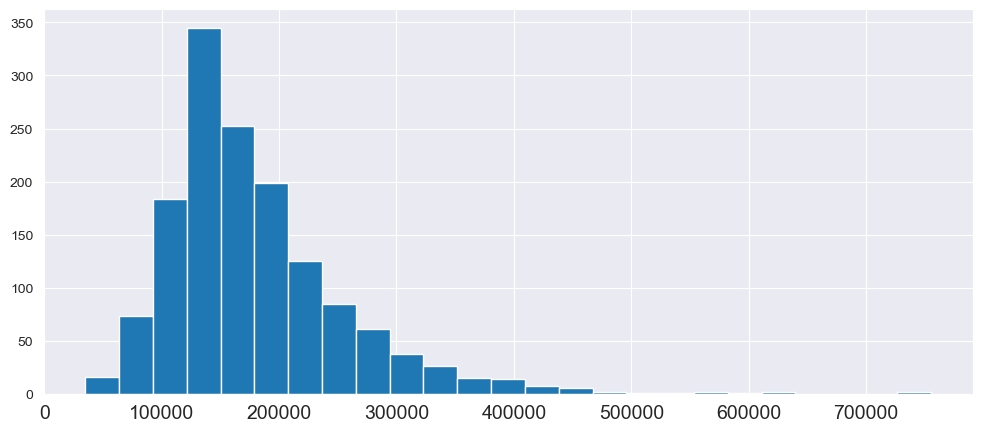

In [6]:
df["SalePrice"].hist(bins=25)

This distribution matches our intuition, and as it's a toy dataset, the target data looks quite clean.

##### Features

Let us now look at the features.

We'll use an LLM to parse the data description, which is around 12,000 characters.
In reality, we may not have such detailed documentation of the features, but will have to rely on domain knowledge. We'd likely interview subject matter experts internally to understand the data and its business meaning better, and conduct some basic research in to the key drivers of the problem.

Here's a summary of the areas covered by our feature set:
- Structural Features (Primary Building Characteristics)
- Lot and Location Attributes
- Interior Features (Layout & Quality)
- Basement Features
- Garage, Parking & Driveway
- Utilities, Heating, and HVAC Systems
- Exterior Additions & Features
- Sales Information

Let's look at the following features first, which seem to mirror what most people would primarily consider when buying a home:

    1.	OverallQual: The overall quality of materials and finishes is a key indicator of property value.
    2.	GrLivArea: The above-ground living area strongly influences a house’s market value.
    3.	Neighborhood: Location is critical, as property prices vary significantly by neighborhood.
    4.	YearBuilt/YearRemodAdd: Age and recent updates are important predictors of marketability and value.
    5.	TotalBsmtSF/GarageArea: Additional space for storage, vehicles, or recreation adds value.
    6.	LotArea: Larger lot sizes usually contribute to higher prices, especially in desirable areas.

In [7]:
key_drivers = pd.Index(["OverallQual", "GrLivArea", "Neighborhood", "YearBuilt", "YearRemodAdd", "TotalBsmtSF", "GarageArea", "LotArea"])

And we can combine this qualitative starting point with some assessment of correlations between numeric features and the target variable:

In [8]:
numeric_cols = df.columns[df.dtypes.apply(pd.api.types.is_numeric_dtype)]

In [9]:
corrs = pd.DataFrame({
    corr_method: df[numeric_cols].corr(method=corr_method)["SalePrice"].drop("SalePrice")
    
    # Take both linear and nonlinear correlation into account
    for corr_method in ["pearson", "spearman"]
})

In [10]:
corrs_ranked = corrs.abs().max(axis=1).sort_values(ascending=False)

<Axes: >

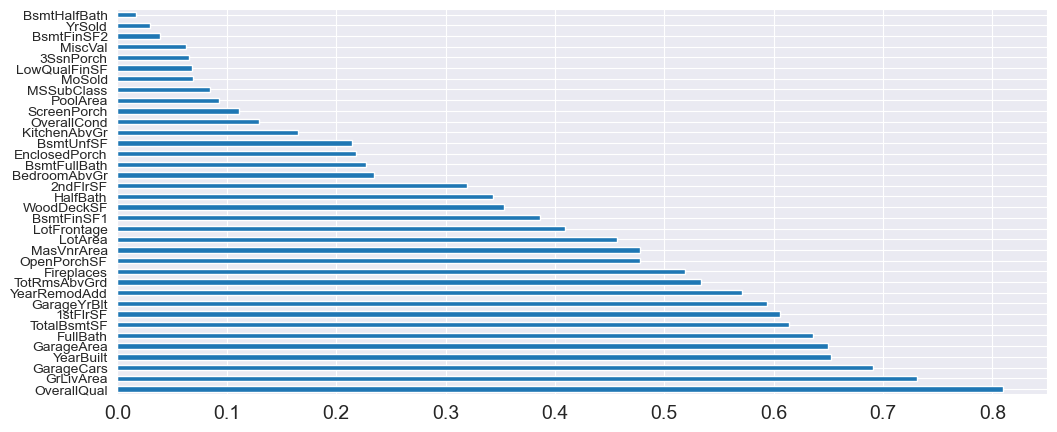

In [11]:
corrs_ranked.plot(kind="barh")

This is a necessary but not sufficient step to determine the top features. Some of the lower-ranked features may end up being very significant in niche situations, or simply require outlier removal or data processing to reveal their feature importance.

However, this gives us a good starting point, owing to the cleanliness of the toy dataset, and the fact that the features have already been preprocessed to some extent.

Let's just take as many of the top features as we can handle in the first pass, and include them in our initial set under scrutiny.

In [12]:
# This utility function tracks changes to the shape of a dataframe.
# In this case we want to see how many top-correlated features we added
with Compare(key_drivers.to_frame()) as cm:
    key_drivers = key_drivers.union(
            corrs_ranked[corrs_ranked.ge(0.5)].index
        )
    cm.register(key_drivers.to_frame())

Shape before: (8, 1)
Shape after:  (14, 1)
Added 6 (75.0%) rows



In [13]:
df = df[key_drivers.union({"SalePrice"})].copy()

##### Check for presence of significant groups, for data partitioning

Sometimes the data may be structured into groups where each group partition has a significantly different range for the data, or different data characteristics. Let's check for these up front, as they may indicate whether we can get a better benchmark, or whether we may need to consider hierarchical modelling.

We expect such groups to be true categoricals, not bins of numeric variables. The "Neighborhood" feature may qualify, so let's try to examine those groups now.

In [14]:
df["Neighborhood"].nunique()

25

In [15]:
pd.DataFrame({
    "abs": df["Neighborhood"].value_counts(),
    "rel": df["Neighborhood"].value_counts(normalize=True)
}).head()

,abs,rel
Neighborhood,,
NAmes,225,0.154110
CollgCr,150,0.102740
OldTown,113,0.077397
Edwards,100,0.068493
Somerst,86,0.058904


<Axes: xlabel='Neighborhood', ylabel='SalePrice'>

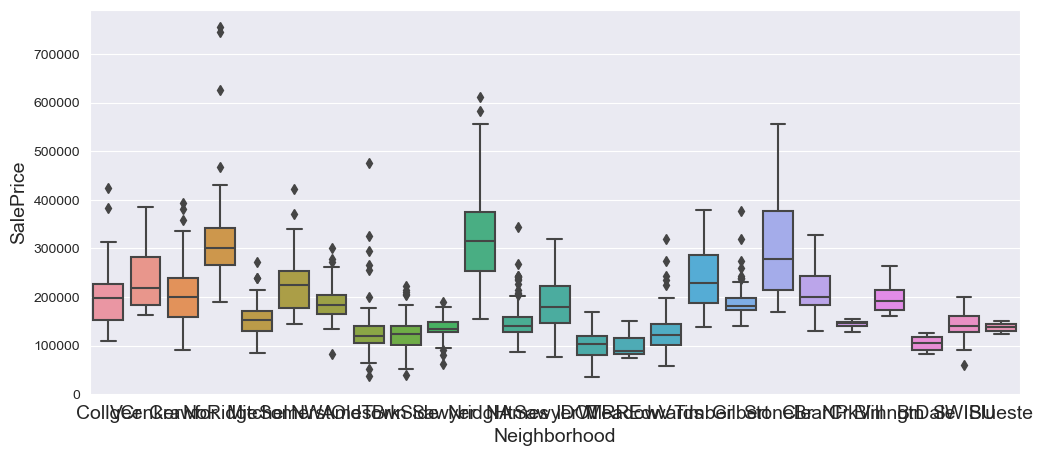

In [16]:
sns.boxplot(data=df, x="Neighborhood", y="SalePrice")

We do see substantial variation within these groups. Although the target medians are not orders of magnitude apart, this grouping will definitely be useful for modelling.

At a minimum, we can take the mean of these groups over the training data to provide a grouped mean benchmark.

#### Sense-check the initial feature set

As these will be the features we will use for training, let's look for anything out of the ordinary, using the `.describe` method to give us an intuition for each variables' distribution.

In [17]:
df.describe().apply(round).map(int).drop(["count", "std"]).T.drop("SalePrice")

,mean,min,25%,50%,75%,max
1stFlrSF,1163,334,882,1087,1391,4692
Fireplaces,1,0,0,1,1,3
FullBath,2,0,1,2,2,3
GarageArea,473,0,334,480,576,1418
GarageCars,2,0,1,2,2,4
GarageYrBlt,1979,1900,1961,1980,2002,2010
GrLivArea,1515,334,1130,1464,1777,5642
LotArea,10517,1300,7554,9478,11602,215245
OverallQual,6,1,5,6,7,10
TotRmsAbvGrd,7,2,5,6,7,14


- The oldest building was 136 years old at time of sale
- The largest property was 200K sqft in area (140m by 140m)
- The most luxurious property could have 3 fireplaces, 3 bathrooms and space for 4 cars

All of these features seem very reasonable and we don't see any outliers in this set.

#### Initial benchmark

Before we proceed further, we need to establish what is our benchmark performance on the data. Every hour that we spend improving our prediction should be measured against this benchmark, in order for us to gauge the ROI of our efforts.

Our metrics will be RMSE (as this is typically what we will try to optimize), and MAE (as this is the more business friendly metric).

In [18]:
from sklearn.metrics import root_mean_squared_error as RMSE, mean_absolute_error as MAE

##### Cross-validation

We will need to do cross-validation at this stage - it is quickest to use vanilla `train_test_split` from Sklearn, but it will not give us a reliable benchmark, as the error could vary significantly between splits.


Often it is worth considering whether a time series split is appropriate - even for problems that are not strictly time series, each record usually has an associated date and time, and there may be seasonal or trend effects in the data.

In our case, we don't really expect the sale price for a house to be seasonally determined, though there may be trend components. It's worth a second look, but for now we can assume the problem is time-independent regression, not a forecast with a specific horizon. We'll go with a simple `KFold` split.

In [19]:
from sklearn.model_selection import KFold

In [20]:
N_SPLITS = 10

In [21]:
kfcv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

In [22]:
XyTuple = tuple[pd.DataFrame, pd.Series]

def cv_split_df(train_idx, test_idx, df: pd.DataFrame) -> tuple[XyTuple, XyTuple]:
    
    X_train = df.drop("SalePrice", axis=1).iloc[train_idx]
    y_train = df.iloc[train_idx]["SalePrice"]
    X_test = df.drop("SalePrice", axis=1).iloc[test_idx]
    y_test = df.iloc[test_idx]["SalePrice"]

    return (X_train, y_train), (X_test, y_test)

##### Benchmark model

Let's use the information about the neighbourhood to arrive at a group-based mean benchmark.

In [23]:
class GroupbyAggBenchmarkModel:
    """Fit groupby and agg to the data and use these for prediction.

    Param `agg_func_name` will be passed to Pandas `agg` method.
    """

    def __init__(self, groupby_cols: list[str], agg_func_name: str = "mean"):
        self.groupby_cols = groupby_cols
        self.agg_func_name = agg_func_name

    def fit(self, X: pd.DataFrame, y: pd.Series):
        Xy = X.assign(target=y)
        self.group_aggs = Xy.groupby(self.groupby_cols)["target"].agg(self.agg_func_name)
        self.global_agg = y.agg(self.agg_func_name)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        y_pred = pd.merge(
            X,
            self.group_aggs,
            how="left",
            on=self.groupby_cols
        )["target"]
        y_pred = y_pred.fillna(self.global_agg)
        return y_pred

In [24]:
bm = GroupbyAggBenchmarkModel(groupby_cols=["Neighborhood"])

In [25]:
rmses = []
maes = []

for train_idx, test_idx in kfcv.split(df.index):
    (X_train, y_train), (X_test, y_test) = cv_split_df(train_idx, test_idx, df)

    bm.fit(X_train, y_train)
    y_pred = bm.predict(X_test)

    k_rmse = RMSE(y_test, y_pred)
    k_mae = MAE(y_test, y_pred)


    rmses.append(k_rmse)
    maes.append(k_mae)

rmses = pd.Series(rmses)
maes = pd.Series(maes)

##### Summary of CV results

In [26]:
rmses.agg(['mean', 'min'])

mean    54264.830521
min     49786.920809
dtype: float64

In [27]:
# Even though we are not evaluating on a relative metric, it's useful to check, to contextualize our result.
# We are currently about 30% off from the eventual sale price:

print("Relative (%) RMSE:", rmses.mean() / df["SalePrice"].mean())

Relative (%) RMSE: 0.2999362802914976


In [28]:
best_mean_rmse = rmses.mean()

##### Examining residuals

Let's examine the residuals when we apply the last trained benchmark model to the whole dataset.

In [29]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]
y_pred = bm.predict(X)

In [30]:
res = y - y_pred

<Axes: >

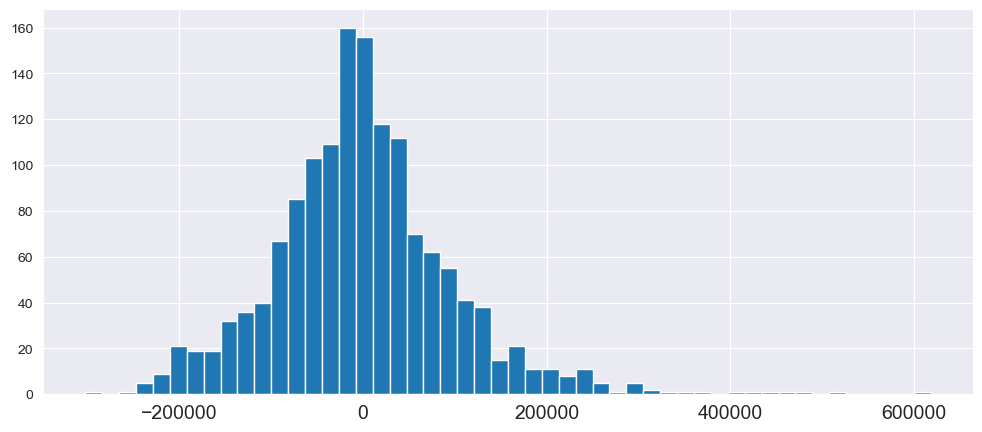

In [31]:
res.hist(bins=50)

In [32]:
res.abs().describe(percentiles=[0.25, 0.50, 0.75, 0.95])

count      1459.000000
mean      72139.598473
std       67924.899885
min           2.000000
25%       21739.236947
50%       53983.969231
75%      100311.496076
95%      201987.128205
max      617874.000000
dtype: float64

In [33]:
best_95p = res.abs().quantile(0.95)

### Machine learning benchmark

Now let's use our initial feature set to train a quick model.

First we should examine the features to check for any obviously required feature engineering.

In [34]:
df[key_drivers].head()

,1stFlrSF,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,LotArea,Neighborhood,OverallQual,TotRmsAbvGrd,TotalBsmtSF,YearBuilt,YearRemodAdd
Id,,,,,,,,,,,,,,
1,856,0,2,548,2,2003.0,1710,8450,CollgCr,7,8,856,2003,2003
2,1262,1,2,460,2,1976.0,1262,9600,Veenker,6,6,1262,1976,1976
3,920,1,2,608,2,2001.0,1786,11250,CollgCr,7,6,920,2001,2002
4,961,1,1,642,3,1998.0,1717,9550,Crawfor,7,7,756,1915,1970
5,1145,1,2,836,3,2000.0,2198,14260,NoRidge,8,9,1145,2000,2000


We can see some year features - but the importance of these is relative to the year it was sold. We don't really care that a house was built in 1960, but rather that it was 60 years old compared to year of sale. We have this variable as "YrSold", so let's subtract this from the relevant features.

In [35]:
df["YrSold"] = df_import["YrSold"]

for yr_col_name in ["GarageYrBlt", "YearBuilt", "YearRemodAdd"]:
    df.loc[df[yr_col_name].notnull(), yr_col_name] -= df.loc[df[yr_col_name].notnull(), "YrSold"]

df = df.drop("YrSold", axis=1)

Now, let's choose a model for our first ML benchmark. We can apply the following considerations:
- Should work well out-of-the-box on structured data. Minimal feature engineering and additional transformers required to set up
- Ideally, handle categorical features easily
- Quick to train
- Decent explainability
- Shouldn't overfit too much

We can go for a gradient boosting trees model to start - these fit most of our requirements well. They do have a risk of overfitting on our small dataset, so we need to make sure we don't allow the model too much room to memorize the data, by controlling the splitting and depth parameters as needed.

In [36]:
import lightgbm as lgb

In [37]:
model_params = {"verbosity": 0}

In [38]:
# LightGBM accepts categoricals as integer-encoded labels
from sklearn.preprocessing import LabelEncoder

In [39]:
cat_cols = df.columns[df.dtypes.eq("object")]

In [40]:
label_encoders = {}

for cat_col in cat_cols:
    enc = LabelEncoder()
    df[cat_col] = enc.fit_transform(df[cat_col])
    label_encoders[cat_col] = enc

##### Train

In [41]:
%%time
rmses = []
maes = []

rmses_train = []

for train_idx, test_idx in kfcv.split(df.index):
    (X_train, y_train), (X_test, y_test) = cv_split_df(train_idx, test_idx, df)

    Xy_train = lgb.Dataset(X_train, y_train)
    Xy_test = lgb.Dataset(X_test, y_test)

    model = lgb.train(model_params,
                      Xy_train,
                      100,
                      valid_sets=[Xy_train, Xy_test],
                      callbacks=[lgb.early_stopping(stopping_rounds=10)])
                    

    
    y_pred = model.predict(X_test)

    k_rmse = RMSE(y_test, y_pred)
    k_mae = MAE(y_test, y_pred)

    rmses.append(k_rmse)
    maes.append(k_mae)

    # bookkeeping of training RMSEs, for later comparison
    y_pred_train = model.predict(X_train)
    rmses_train.append(RMSE(y_train, model.predict(X_train)))

rmses = pd.Series(rmses)
maes = pd.Series(maes)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	training's l2: 2.34206e+08	valid_1's l2: 1.11176e+09
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	training's l2: 3.97566e+08	valid_1's l2: 5.96993e+08
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	training's l2: 6.2078e+08	valid_1's l2: 4.96472e+08
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's l2: 2.29323e+08	valid_1's l2: 8.74181e+08
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's l2: 8.91439e+08	valid_1's l2: 1.33502e+09
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	training's l2: 5.26935e+08	valid_1's l2: 1.52931e+09
Training until validation scores don't improve for 10 rounds
Early stopping, 

##### Summary of CV results

In [42]:
rmses.agg(['mean', 'min'])

mean    28695.092972
min     21137.591717
dtype: float64

##### Examining residuals

We'll take the last trained model and examine the residuals when applied to the whole dataset.

In [43]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]
y_pred = model.predict(X)

In [44]:
res = y - y_pred

<Axes: >

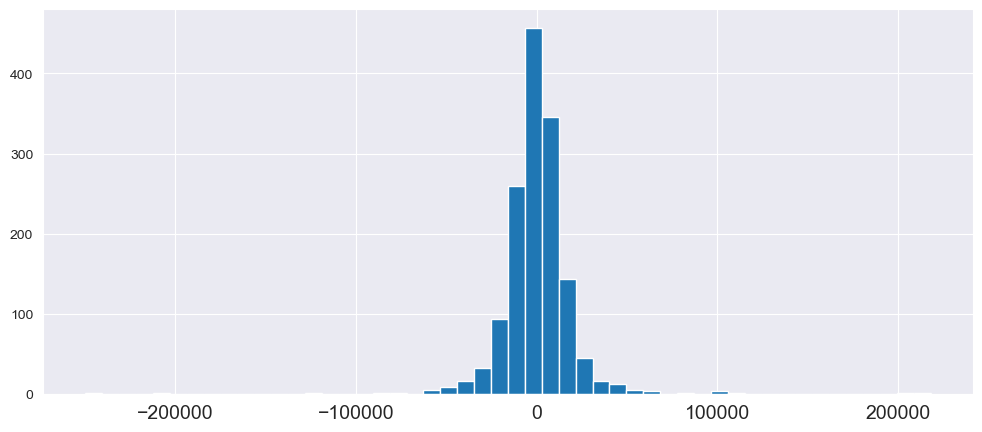

In [45]:
res.hist(bins=50)

In [46]:
res.abs().describe(percentiles=[0.25, 0.50, 0.75, 0.95])

count      1460.000000
mean      11853.659089
std       16747.485144
min           9.891207
25%        3606.686653
50%        7697.038382
75%       14370.059573
95%       34838.859486
max      249855.149122
Name: SalePrice, dtype: float64

In [47]:
res.abs().quantile(0.95)

34838.85948606627

In [48]:
print("Relative (%) RMSE:", rmses.mean() / df["SalePrice"].mean())
print("Improvement (%) on best (mean over K folds) RMSE:", (rmses.mean() / best_mean_rmse) - 1)
print("Improvement (%) on best 95th perc of abs errors:", (res.abs().quantile(0.95) / best_95p) - 1)

Relative (%) RMSE: 0.15860547920046314
Improvement (%) on best (mean over K folds) RMSE: -0.47120275331040307
Improvement (%) on best 95th perc of abs errors: -0.8275194078174841


##### Under-/Overfitting check

<Axes: >

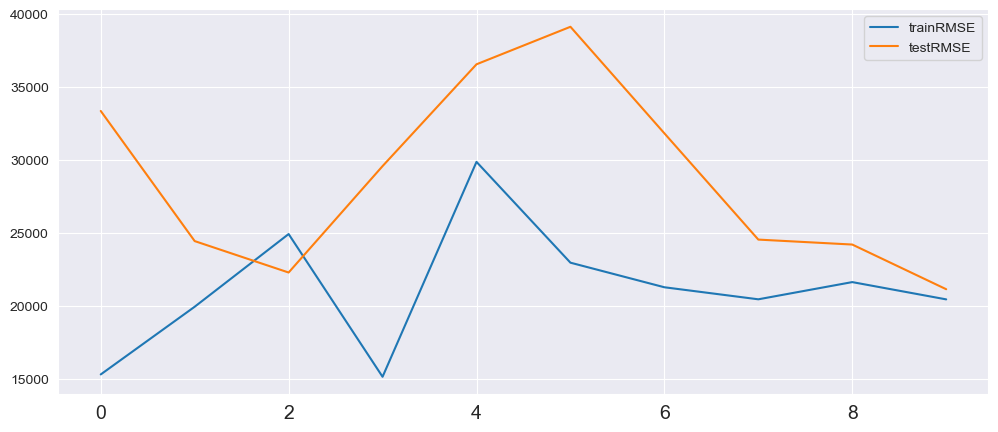

In [49]:
pd.DataFrame({
    "trainRMSE": rmses_train,
    "testRMSE": rmses
}).plot()

Our generalization seems within reasonable bounds - there are some CV splits {2, 9} where we were underfitting to the test data, and a few {0, 5} where we were overfitting.

##### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

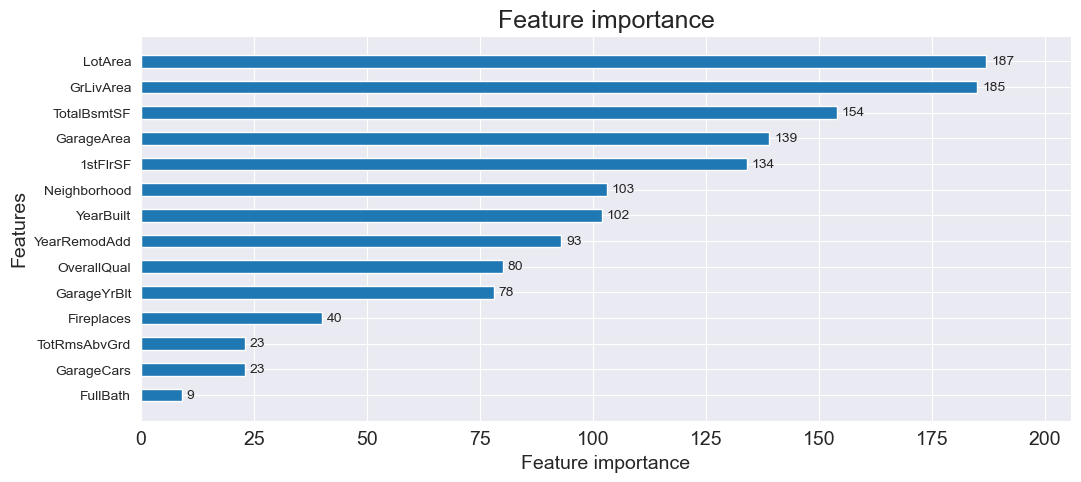

In [62]:
lgb.plot_importance(model, height=0.5, importance_type="auto")

In [51]:
import shap

In [52]:
%%time
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent", feature_names=df.columns)

CPU times: user 13.4 ms, sys: 1.14 ms, total: 14.5 ms
Wall time: 13.6 ms


In [53]:
shap_values = explainer(X_test)

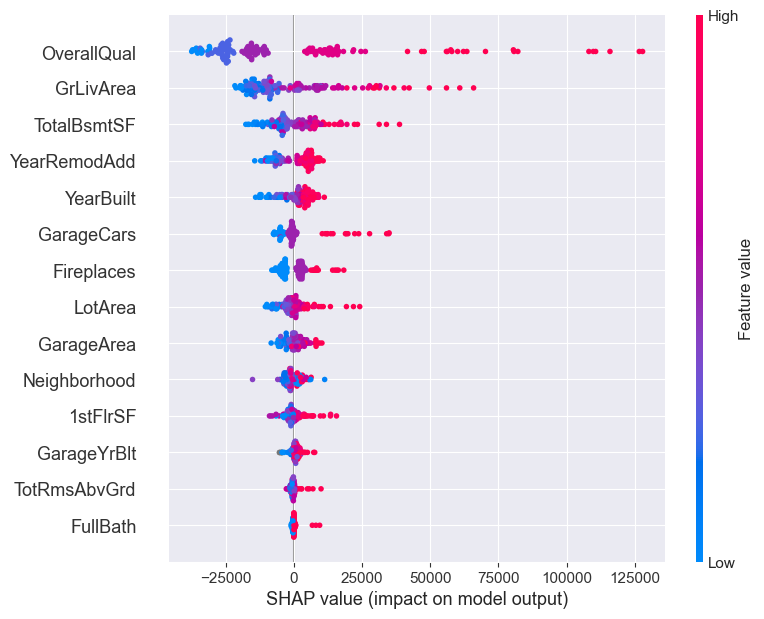

In [54]:
shap.plots.beeswarm(shap_values, max_display=15)

As we expected, based on how we selected our first feature set, all features so far are relevant. If we want to continue improving the model, there is scope to look at the remaining features and engineer combinations of these.

#### Checkpoint

With the quick LightGBM model:
- We are 29,000 USD (16%) off from the eventual sale price
- 5% of our predictions are more than 39,000 USD (22%) off.

This marks a significant improvement over the simple (very naive) benchmark, and was achieved in only a few hours of work.


The implementation in production would be relatively quick given the very low number of features and degree feature engineering we have applied. If we were happy with the model, we could run the final check against the test dataset to measure its performance. **It is important not to make any further design choices after measuring the final model performance** - or else the final performance will be biased.

We can stop the analysis here for now while we wait for feedback from our internal stakeholders, to see whether this level of prediction error is satisfactory.

If that is not the case, we would proceed with the next phase of the experiment, analysing and engineering more features, and using our best model as the benchmark.

___